In [1]:

import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda:0


In [2]:
GROUNDING_DINO_CONFIG_PATH = '/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py'
GROUNDING_DINO_CHECKPOINT_PATH = 'weights/groundingdino_swint_ogc.pth'

In [3]:
from groundingdino.util.inference import load_model, load_image, predict, annotate, Model
GD_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)


final text_encoder_type: bert-base-uncased


In [5]:
import cv2
image_bgr = cv2.imread('weights/12.png')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_original = image_bgr

print(image_bgr.shape)

image_bgr = cv2.resize(image_bgr, (1024, 1024))
image_rgb = cv2.resize(image_rgb, (1024, 1024))
image_original = cv2.resize(image_original, (1024, 1024))

print(image_bgr.shape)



(712, 1183, 3)
(1024, 1024, 3)


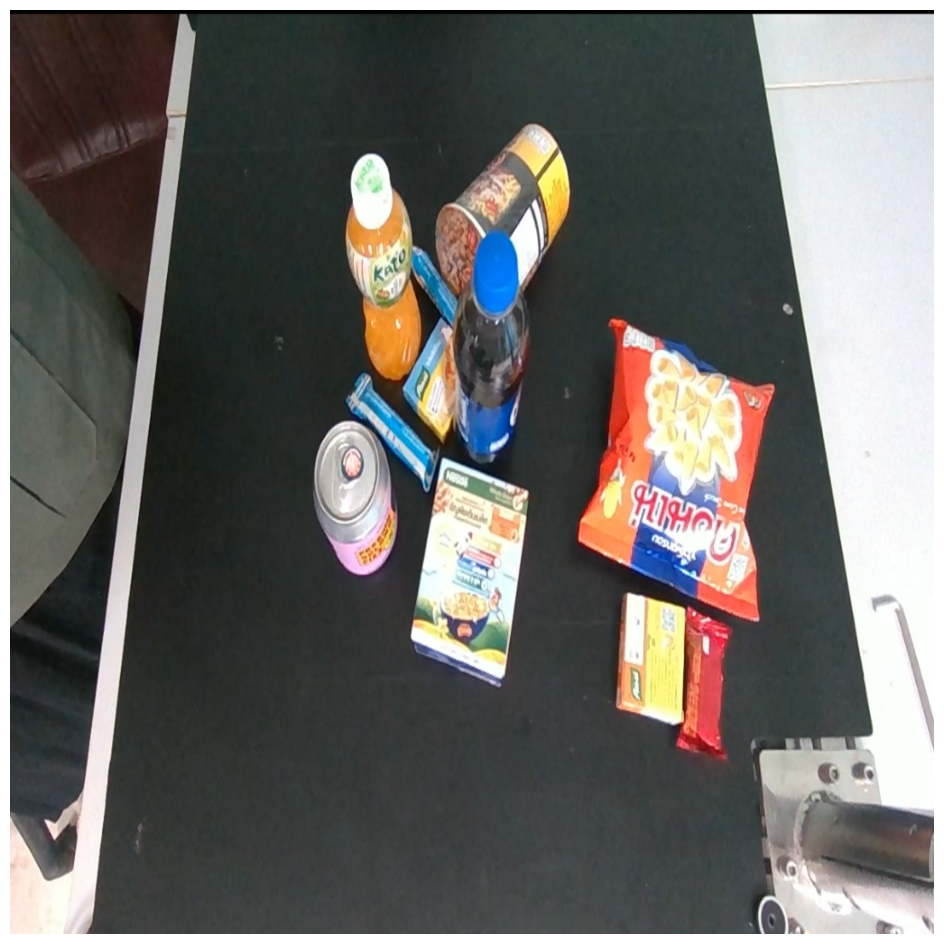

In [6]:
import supervision as sv
sv.plot_image(image_bgr)

In [7]:
# detect objects
CLASSES = ['product']
detections = GD_model.predict_with_classes(
    image=image_rgb,
    classes=CLASSES,
    box_threshold=0.30,
    text_threshold=0.25
)

print(detections)

Detections(xyxy=array([[442.69913 , 495.4056  , 576.12317 , 750.9573  ],
       [369.8272  , 157.60107 , 456.73798 , 410.2801  ],
       [334.501   , 453.698   , 430.11307 , 627.7854  ],
       [488.40656 , 244.52754 , 577.1413  , 503.62286 ],
       [469.72046 , 123.968834, 621.6355  , 321.75867 ],
       [627.9505  , 340.24902 , 848.65704 , 677.54443 ],
       [370.637   , 401.14618 , 476.5281  , 534.63403 ],
       [670.4143  , 644.20087 , 750.1273  , 793.1624  ],
       [434.28244 , 339.5696  , 495.63638 , 481.4785  ],
       [737.38324 , 660.83844 , 798.7093  , 830.5942  ]], dtype=float32), mask=None, confidence=array([0.5250796 , 0.47240078, 0.48642188, 0.48274735, 0.47863415,
       0.45465654, 0.38808852, 0.38005117, 0.36266425, 0.3377924 ],
      dtype=float32), class_id=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), tracker_id=None, data={})


In [10]:
print(detections.xyxy, type(detections.xyxy))
detected_boxes = detections.xyxy
class_id = detections.class_id
print(class_id)

[[442.69913  495.4056   576.12317  750.9573  ]
 [369.8272   157.60107  456.73798  410.2801  ]
 [334.501    453.698    430.11307  627.7854  ]
 [488.40656  244.52754  577.1413   503.62286 ]
 [469.72046  123.968834 621.6355   321.75867 ]
 [627.9505   340.24902  848.65704  677.54443 ]
 [370.637    401.14618  476.5281   534.63403 ]
 [670.4143   644.20087  750.1273   793.1624  ]
 [434.28244  339.5696   495.63638  481.4785  ]
 [737.38324  660.83844  798.7093   830.5942  ]] <class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0]


In [11]:
import supervision as sv
box_annotator = sv.BoxAnnotator()
annotated_frame = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=False, labels=[class_id])
sv.plot_image(annotated_frame)


TypeError: BoxAnnotator.annotate() got an unexpected keyword argument 'skip_label'

In [9]:
MODEL_TYPE = "vit_h"
import torch
import os
from segment_anything import sam_model_registry, SamPredictor
MODEL_TYPE = "vit_h"

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CHECKPOINT_PATH = 'weights/sam_vit_h_4b8939.pth'

# ตรวจสอบเส้นทางของไฟล์
if not os.path.isfile(CHECKPOINT_PATH):
    raise FileNotFoundError(f"Checkpoint file not found at: {CHECKPOINT_PATH}")

# โหลดโมเดล
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

# สร้าง SamPredictor
mask_predictor = SamPredictor(sam)


c:\Users\Thiraphat\anaconda3\envs\dino\lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [10]:
import numpy as np
mask_annotator =  sv.MaskAnnotator(color=sv.Color.blue())
segmented_mask = []
counter = 0
for mybox in detected_boxes:
    mybox = np.array(mybox)
    print(mybox)


    mask_predictor.set_image(image_rgb)
    masks, scores, logits = mask_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=mybox,
        multimask_output=False
    )

    segmented_mask.append(masks)
    print(len(masks), masks.shape)

# plot mask on image using supervision
    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks),
        mask=masks
    )

    detections = detections[detections.area == np.max(detections.area)]
    print(CLASSES[class_id[counter]])

    annotated_image = box_annotator.annotate(scene=image_original.copy(), detections=detections, skip_label=False, labels=[CLASSES[class_id[counter]]])
    annotated_image = mask_annotator.annotate(scene=annotated_image.copy(), detections=detections)
    image_original = annotated_image

    counter+=1

[442.69913 495.4056  576.12317 750.9573 ]
1 (1, 1024, 1024)
product
[369.8272  157.60107 456.73798 410.2801 ]
1 (1, 1024, 1024)
product
[334.501   453.698   430.11307 627.7854 ]
1 (1, 1024, 1024)
product
[488.40656 244.52754 577.1413  503.62286]
1 (1, 1024, 1024)
product
[469.72046  123.968834 621.6355   321.75867 ]
1 (1, 1024, 1024)
product
[627.9505  340.24902 848.65704 677.54443]
1 (1, 1024, 1024)
product
[370.637   401.14618 476.5281  534.63403]
1 (1, 1024, 1024)
product
[670.4143  644.20087 750.1273  793.1624 ]
1 (1, 1024, 1024)
product
[434.28244 339.5696  495.63638 481.4785 ]
1 (1, 1024, 1024)
product
[737.38324 660.83844 798.7093  830.5942 ]
1 (1, 1024, 1024)
product


Plot image using Supervion

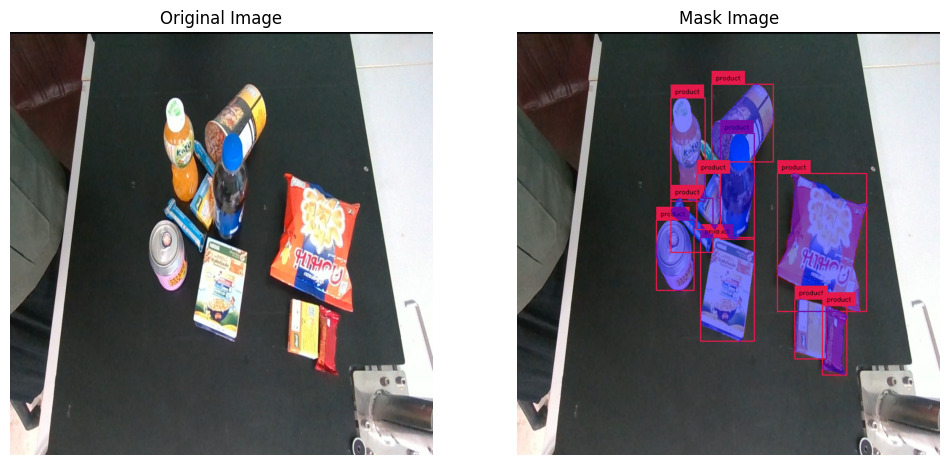

In [12]:
sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1,2),
    titles=['Original Image', 'Mask Image']

)

In [13]:
print(len(segmented_mask), type(segmented_mask[0]), segmented_mask[0].shape)

for i in range(len(segmented_mask)):

  segmented_mask[i] = segmented_mask[i].transpose(1,2,0)
  segmented_mask[i] = np.array(segmented_mask[i]*255).astype('uint8')
  segmented_mask[i]  = cv2.cvtColor(segmented_mask[i] , cv2.COLOR_GRAY2BGR)


print(segmented_mask[0].shape)

10 <class 'numpy.ndarray'> (1, 1024, 1024)
(1024, 1024, 3)


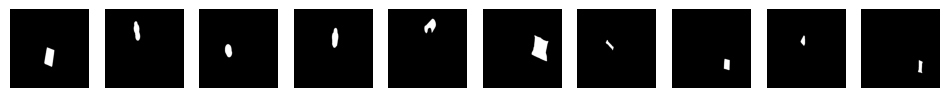

In [14]:
sv.plot_images_grid(
    images=segmented_mask,
    grid_size=(1, len(segmented_mask)),

)

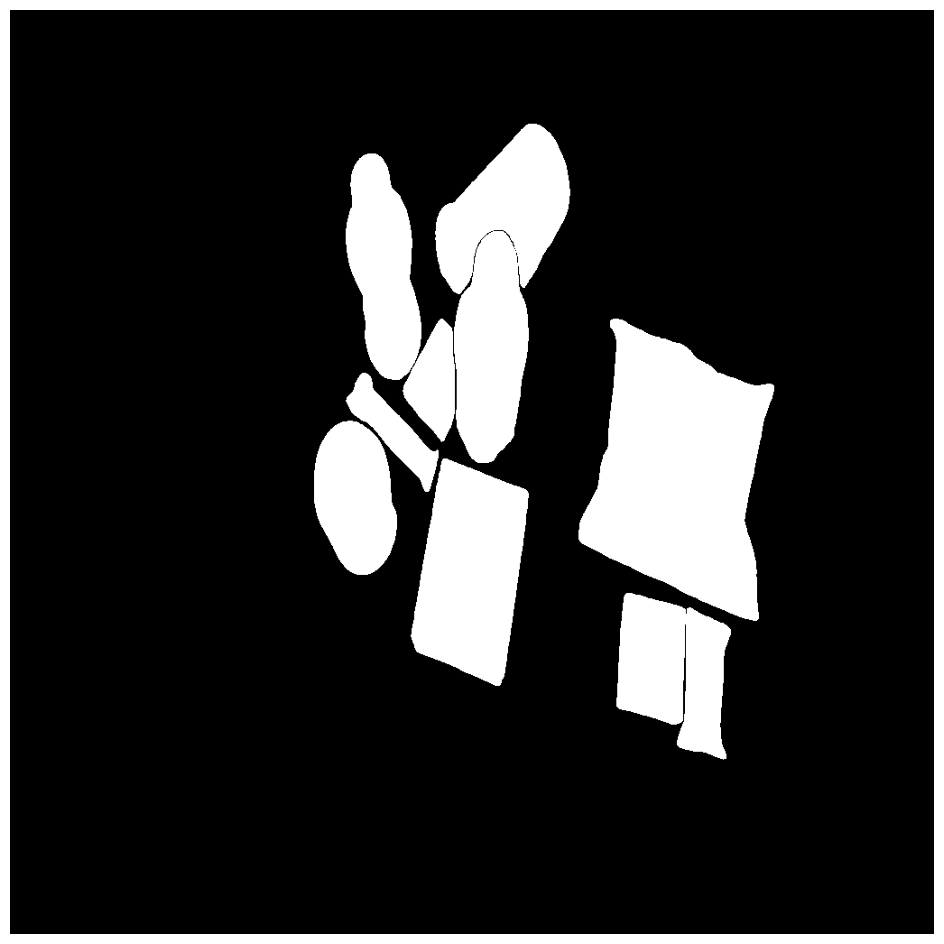

In [15]:
segmented_image = segmented_mask[0]

for i in range(len(segmented_mask)):
  try:
    segmented_image = cv2.bitwise_or(segmented_image, segmented_mask[i+1])
  except:
    pass

sv.plot_image(segmented_image)

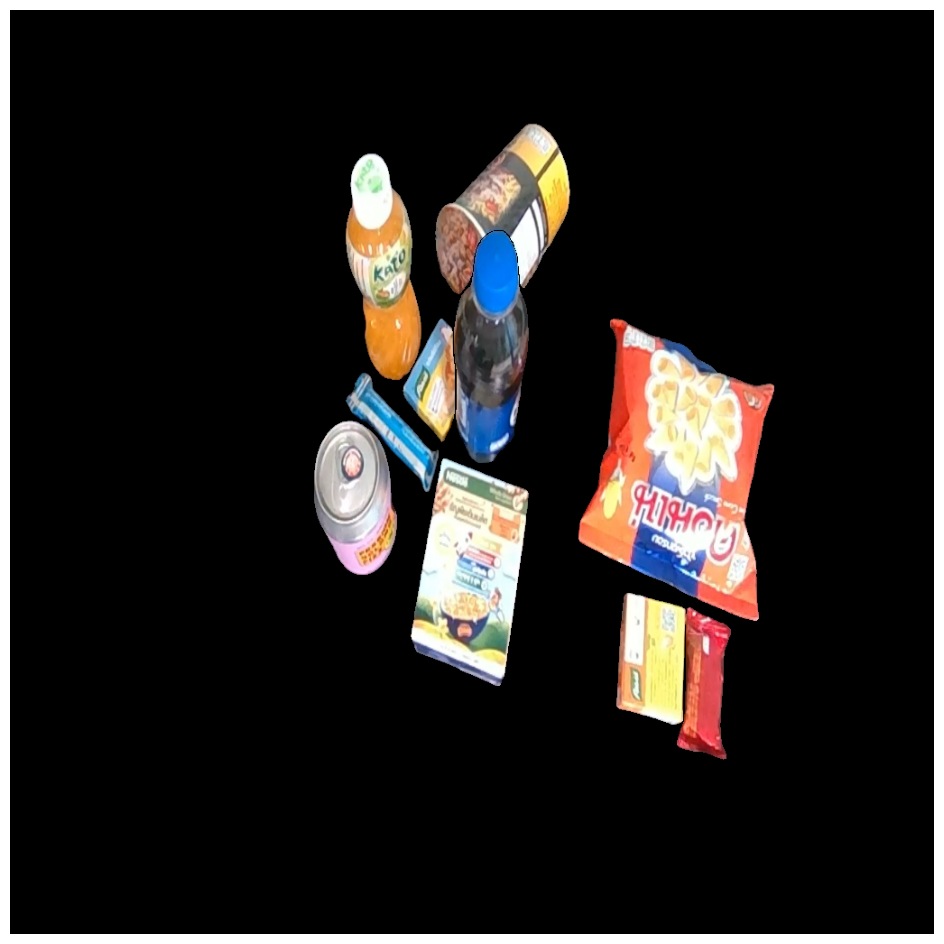

In [16]:
segmented_image = cv2.bitwise_and(segmented_image, image_bgr)
sv.plot_image(segmented_image)

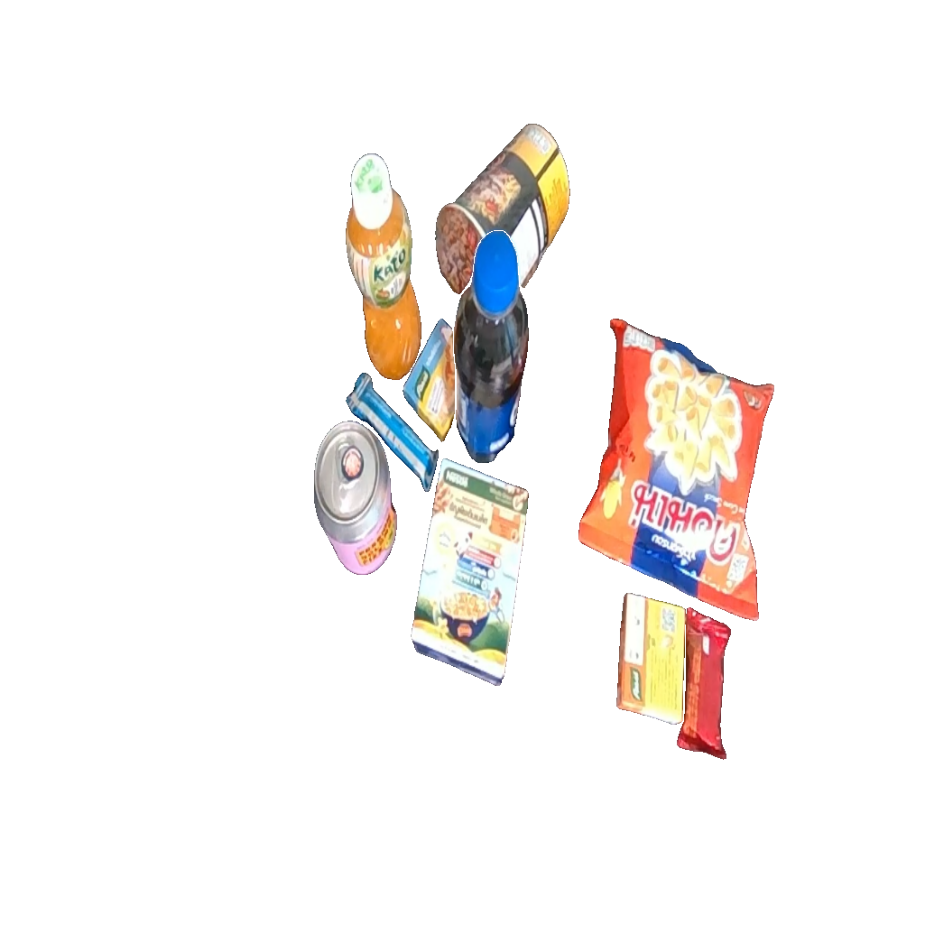

In [17]:
segmented_image[np.where((segmented_image == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
sv.plot_image(segmented_image)

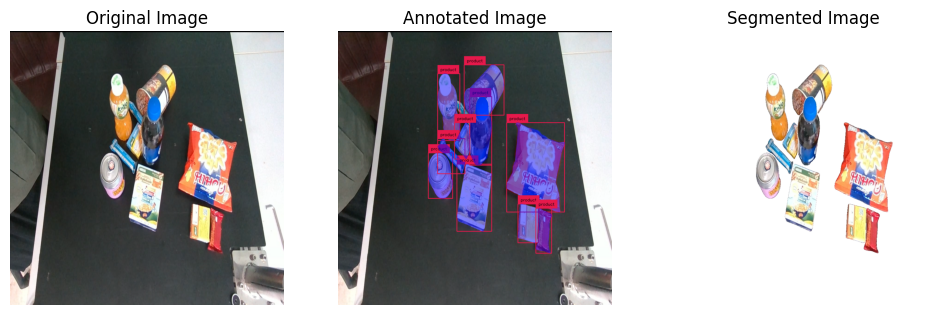

In [18]:
sv.plot_images_grid(
    images=[image_bgr, annotated_image, segmented_image],
    grid_size=(1, 3),
    titles=['Original Image', 'Annotated Image', 'Segmented Image'],
    #size=(48,48)

)